In [1]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns
import json

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)

# Below code is for enabling only particular GPU cards.
# Testing machine contained in total 6 GPUs, but for training only 5 of them were used.
# If your testing set contains less or one card, you need to change it accordingly.
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[0]], 'GPU')

In [2]:
data_dir = '../data'

In [3]:
historic_data_in_minibatch = 250

In [4]:
ema_lengths = [3, 5, 8, 9, 10, 13, 20, 21, 26, 34, 50, 55, 89, 100, 144, 200, 233, historic_data_in_minibatch]
len(ema_lengths)

18

# Data loading

In [5]:
# Loading data from already prepared datasets
X_train, y_train = (
    np.load(os.path.join(data_dir, 'X_train_shuffled_crypto_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_train_shuffled_crypto_with_mean_model.npz')))
X_train, y_train = X_train['arr_0'], y_train['arr_0']

X_valid, y_valid = (
    np.load(os.path.join(data_dir, 'X_valid_shuffled_crypto_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_valid_shuffled_crypto_with_mean_model.npz')))
X_valid, y_valid = X_valid['arr_0'], y_valid['arr_0']

X_test, y_test = (
    np.load(os.path.join(data_dir, 'X_test_shuffled_crypto_with_mean_model.npz')), 
    np.load(os.path.join(data_dir, 'y_test_shuffled_crypto_with_mean_model.npz')))
X_test, y_test = X_test['arr_0'], y_test['arr_0']

In [7]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1])
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1])
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1])

## Data scaling

In [8]:
from pickle import dump

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)



In [9]:
X_train = X_train.reshape((X_train.shape[0]), X_train.shape[1], 1)
X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)
X_valid = X_valid.reshape((X_valid.shape[0]), X_valid.shape[1], 1)

In [11]:
features_number = X_train.shape[1]

### Split for two model inputs

In [12]:
X_train_CNN, X_train_Dense = X_train[:, :historic_data_in_minibatch, :], X_train[:, historic_data_in_minibatch:, :] 
X_test_CNN, X_test_Dense = X_test[:, :historic_data_in_minibatch, :], X_test[:, historic_data_in_minibatch:, :] 
X_valid_CNN, X_valid_Dense = X_valid[:, :historic_data_in_minibatch, :], X_valid[:, historic_data_in_minibatch:, :] 

In [15]:
len(y_train), len(y_valid), len(y_test)

(1148002, 327662, 164870)

# y categorization

In [17]:
one_ids = np.where(y_train >= 0.9)
zero_ids = np.where(y_train < 0.9)

y_train[one_ids[0], one_ids[1]] = 1
y_train[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_train = y_train.astype(np.int)

Positive %: 0.04093721091078239
Negative %: 0.9590627890892176


In [18]:
one_ids = np.where(y_valid >= 0.9)
zero_ids = np.where(y_valid < 0.9)

y_valid[one_ids[0], one_ids[1]] = 1
y_valid[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_valid = y_valid.astype(np.int)

Positive %: 0.04011756016871044
Negative %: 0.9598824398312895


In [19]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.047182628737793414
Negative %: 0.9528173712622066


In [20]:
y_all = np.concatenate((y_train, y_valid, y_test))
temp = np.copy(y_all)
temp.shape

one_ids = np.where(temp >= 0.9)
zero_ids = np.where(temp < 0.9)

temp[one_ids[0], one_ids[1]] = 1
temp[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

unique, counts = np.unique(y_all, return_counts=True)
for val, qty in zip(unique, counts):
    print(f'Label {val}: {qty}')

Positive %: 0.04140115352683943
Negative %: 0.9585988464731605
Label 0: 1572614
Label 1: 67920


In [21]:
neg, pos = np.unique(y_train, return_counts=True)[1]
total = neg + pos
neg, pos, total

(1101006, 46996, 1148002)

In [22]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

Weight for class 0: 0.52
Weight for class 1: 12.21


### Under-sampling majority class
Sample code for dataset undersampling do balance it a little bit. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [2]:
# majority_ids = np.where(y_train == 0)[0]
# minority_ids = np.where(y_train == 1)[0]
# len(majority_ids), len(minority_ids)

In [3]:
# minority_y_train = y_train[minority_ids]
# len(minority_y_train), minority_y_train.shape

In [4]:
# minority_X_train_CNN = X_train_CNN[minority_ids]
# minority_X_train_Dense = X_train_Dense[minority_ids]

In [31]:
# chosen_majority_ids = np.random.choice(majority_ids, int(len(majority_ids)*0.5))

In [5]:
# majority_y_train = y_train[chosen_majority_ids]
# np.unique(majority_y_train, return_counts=True)

In [6]:
# majority_X_train_CNN = X_train_CNN[chosen_majority_ids]
# majority_X_train_Dense = X_train_Dense[chosen_majority_ids]

In [7]:
# new_X_train_CNN = np.concatenate((majority_X_train_CNN, minority_X_train_CNN))
# new_X_train_Dense = np.concatenate((majority_X_train_Dense, minority_X_train_Dense))
# new_y_train = np.concatenate((majority_y_train, minority_y_train))

# new_X_train_CNN.shape, new_X_train_Dense.shape, new_y_train.shape

In [8]:
# counts = np.unique(new_y_train, return_counts=True)[1]
# counts[1]/counts[0]

In [36]:
# X_train_CNN, X_train_Dense, y_train = new_X_train_CNN, new_X_train_Dense, new_y_train

In [9]:
# _temp = y_train.reshape((-1,))
# weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(_temp), y=_temp)
# weights

In [38]:
# class_weight = {0: weights[0], 1: weights[1]}

### DS oversampling
Sample code for dataset oversampling do balance it a little bit. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [23]:
# np.random.seed(42)

In [10]:
# bool_train_labels = y_train != 0
# bool_train_labels.shape

In [11]:
# bool_train_labels = bool_train_labels.reshape((-1,))
# bool_train_labels.shape

In [26]:
# pos_features_CNN = X_train_CNN[bool_train_labels, :, :]
# pos_features_Dense = X_train_Dense[bool_train_labels, :, :]
# neg_features_CNN = X_train_CNN[~bool_train_labels, :, :]
# neg_features_Dense = X_train_Dense[~bool_train_labels, :, :]

# pos_labels = y_train[bool_train_labels]
# neg_labels = y_train[~bool_train_labels]

In [12]:
# pos_features_CNN.shape, pos_features_Dense.shape, neg_features_CNN.shape, neg_features_Dense.shape, pos_labels.shape, neg_labels.shape

In [13]:
# ids = np.arange(len(pos_features_CNN))
# choices = np.random.choice(ids, len(neg_labels))

# res_pos_features_CNN = pos_features_CNN[choices]
# res_pos_features_Dense = pos_features_Dense[choices]
# res_pos_labels = pos_labels[choices]

# res_pos_features_CNN.shape, res_pos_features_Dense.shape

In [14]:
# resampled_features_CNN = np.concatenate([res_pos_features_CNN, neg_features_CNN], axis=0)
# resampled_features_Dense = np.concatenate([res_pos_features_Dense, neg_features_Dense], axis=0)
# resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

# order = np.arange(len(resampled_labels))
# np.random.shuffle(order)
# resampled_features_CNN = resampled_features_CNN[order]
# resampled_features_Dense = resampled_features_Dense[order]
# resampled_labels = resampled_labels[order]

# resampled_features_CNN.shape, resampled_features_Dense.shape

In [15]:
# np.unique(resampled_labels, return_counts=True)

# Classification Model

## TensorBoard config

In [68]:
# Training of this model was initially done from different location,
# and the actual tensorboard metrics can be found in directory `train` and `validation`
# If you want to run your own training based on this notebook,
# please create `my_dictionaries` directory on your own. 
# All TensorBoard metrics will be saved there.
root_logdir = os.path.join(os.curdir, 'my_dictionaries')

try:
    tf.keras.backend.clear_session()
except Exception as err:
    print(err)

def get_run_logdir():
    import time
    run_id = time.strftime('przebieg_%Y_%m_%d-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [1]:
try:
    log.removeHandler(fh)
except Exception as err:
    print("Handler or log instance doesn't exists.")
else:
    print(f'Handler {fh} removed correctly. All handlers:\n{log.handlers}')

In [70]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
directory = os.path.join(run_logdir, 'tensorflow.log')
os.makedirs(run_logdir, exist_ok=True)
open(directory, 'w').close()
fh = logging.FileHandler(directory)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [16]:
train_datapoints = len(y_train)
batch_size = 8000 * 5
steps_per_epoch = int(train_datapoints / (batch_size))
steps_per_epoch

In [72]:
config = {
    'cnn_input_shape': [X_train_CNN.shape[1], 1],
    'kernel_initializer': 'he_normal',
    'statistical_input_shape': [X_train_Dense.shape[1], 1],
    'statistical_dense1_neurons_qty': X_train_Dense.shape[1],
    'batch_size': 8000,
    'n': 80,
    'm': 40,
    'lr_in': 1e-3,
    'lr_max': 0.03,
    'lr_min': 1e-5,
    'momentum_min': 0.8,
    'momentum_max': 0.95
}

In [73]:
import json

with open(os.path.join(run_logdir, 'config.json'), 'w') as config_json:
    json.dump(config, config_json)

In [45]:
dump(scaler, open(os.path.join(run_logdir, 'input_scaler_with_ema_shuffled_crypto.pkl'), 'wb'))

In [74]:
# 1cycle Learning Rate Scheduler
log.info('Using 1cycle Learning Rate Scheduler')

learning_rates = []

_epochs1, _lrs1 = np.array([1, config['n']]).reshape((-1, 1)), np.array([config['lr_in'], config['lr_max']]).reshape((-1, 1))
_epochs2, _lrs2 = np.array([config['n'], 2*config['n']]).reshape((-1, 1)), np.array([config['lr_max'], config['lr_in']]).reshape((-1, 1))
_epochs3, _lrs3 = np.array([2*config['n'], 2*config['n'] + config['m']]).reshape((-1, 1)), np.array([config['lr_in'], config['lr_min']]).reshape((-1, 1))

reg1 = LinearRegression().fit(_epochs1, _lrs1)
reg2 = LinearRegression().fit(_epochs2, _lrs2)
reg3 = LinearRegression().fit(_epochs3, _lrs3)

def one_cycle_lr_scheduler(epoch, curr_lr):
    epoch = epoch + 1
    if epoch <= config['n']:
        lr = reg1.predict(np.array([epoch]).reshape((-1,1)))[0][0]
    elif epoch > config['n'] and epoch <= 2 * config['n']:
        lr = reg2.predict(np.array([epoch]).reshape((-1,1)))[0][0]
    else:
        lr = reg3.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        
    learning_rates.append(lr)
    
    log.info(f'New lr = {lr}, epoch = {epoch}')
    return lr

one_cycle_scheduler = tf.keras.callbacks.LearningRateScheduler(one_cycle_lr_scheduler)

INFO:tensorflow:Using 1cycle Learning Rate Scheduler


In [75]:
# 1cycle Momentum adaptation
log.info('Using 1cycle Momentum')

momentum_rates = []

_momentum_epochs1, _momentums1 = np.array([1, config['n']]).reshape((-1, 1)), np.array([config['momentum_max'], config['momentum_min']]).reshape((-1, 1))
_momentum_epochs2, _momentums2 = np.array([config['n'], 2*config['n']]).reshape((-1, 1)), np.array([config['momentum_min'], config['momentum_max']]).reshape((-1, 1))

momentum_reg1 = LinearRegression().fit(_momentum_epochs1, _momentums1)
momentum_reg2 = LinearRegression().fit(_momentum_epochs2, _momentums2)


class MomentumCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        epoch = epoch + 1
        print(f'Epoch: {epoch}')
#         print(f'Current momentum: {self.model.optimizer.momentum}')
        if epoch <= config['n']: 
            momentum = momentum_reg1.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        elif epoch > config['n'] and epoch <= 2 * config['n']:
            momentum = momentum_reg2.predict(np.array([epoch]).reshape((-1,1)))[0][0]
        else:
            momentum = config['momentum_max']
            
        momentum_rates.append(momentum)
        
        self.model.optimizer.momentum = momentum
        print(f'Updated momentum: {momentum}')


INFO:tensorflow:Using 1cycle Momentum


In [76]:
# Callback for collecting learning rate value over the process of training
custom_lrs = []

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        custom_lrs.append({'epoch': epoch, 'lr': self.model.optimizer._decayed_lr('float32').numpy()})
        print(f"Epoch {epoch}. Current lr = {self.model.optimizer._decayed_lr('float32').numpy()}")

In [17]:
from importlib import import_module, reload
from shutil import copyfile

tf.keras.backend.clear_session()
model_creation = import_module('model_creation_categorical_crypto')
reload(model_creation)

log.info('\n\nBuilding model:\n')
# The quantity of provided devices depends from number of GPUs in local system.
devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
model = model_creation.build_model(config, devices=devices, cust_lr_scheduler=lr_schedule)

copyfile('model_creation_categorical_crypto.py', os.path.join(run_logdir, 'model_creation_categorical_crypto.py'))

In [78]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 1)       4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 128)     5248        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 125, 128)     0           conv1d[0][0]                     
______________________________________________________________________________________________

## Bias correction
Initial bias correction is sometimes performed to adjust early loss value when training data on unbalanced DS. After the tests, in this case it didn't bring any improvement for model training, so was commented out.

In [18]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [19]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

In [20]:
# initial_bias = np.log([pos/neg])
# initial_bias

In [21]:
# from importlib import import_module, reload
# from shutil import copyfile

# tf.keras.backend.clear_session()

# model_creation = import_module('model_creation_categorical_testing')
# reload(model_creation)

# log.info('\n\nBuilding model:\n')
# devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4"]
# # model = model_creation.build_model(config, devices=devices, cust_lr_scheduler=lr_schedule)
# model = model_creation.build_model(config, devices=devices, output_bias=initial_bias)

# copyfile('model_creation_categorical_testing.py', os.path.join(run_logdir, 'model_creation_categorical_testing.py'))

In [22]:
# pos/(total)

In [23]:
# model.predict((X_train_CNN[:10], X_train_Dense[:10]))

In [24]:
# results = model.evaluate((X_train_CNN, X_train_Dense), y_train, batch_size=config['batch_size'] * len(devices))
# print("Loss: {:0.4f}".format(results[0]))

# Model training
All training and validation metrics can be found in tensorboard folders and visualized by tensorboard.

In [25]:
log.info('\n\nModel fitting:\n\n')
history = model.fit(
    (X_train_CNN, X_train_Dense), y_train, 
    epochs=220, 
    batch_size = config['batch_size'] * len(devices), 
    validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
    class_weight=class_weight,
    callbacks=[
        tensorboard_cb, 
        CustomCallback(), 
        one_cycle_scheduler, 
        MomentumCallback()
    ]
)

In [25]:
eval_score = model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)
eval_score

5153/5153 [==============================] - 102s 20ms/step - loss: 0.4761 - tp: 1746.0000 - fp: 6629.0000 - tn: 150462.0000 - fn: 6033.0000 - binary_accuracy: 0.9232 - precision: 0.2085 - recall: 0.2245 - auc: 0.5911 - prc: 0.0977


{'loss': 0.47605234384536743,
 'tp': 1746.0,
 'fp': 6629.0,
 'tn': 150462.0,
 'fn': 6033.0,
 'binary_accuracy': 0.9232000708580017,
 'precision': 0.20847761631011963,
 'recall': 0.22445043921470642,
 'auc': 0.5911259651184082,
 'prc': 0.09770732372999191}

In [94]:
with open(os.path.join(run_logdir, 'eval_score.json'), 'w') as eval_score_json:
    json.dump(eval_score, eval_score_json)

## Learning on balanced DS
In case when DS balancing was performed

In [26]:
# resampled_steps_per_epoch = np.ceil(2.0*neg/(config['batch_size'] * len(devices)))
# resampled_steps_per_epoch

In [27]:
# log.info('\n\nModel fitting:\n\n')
# history = model.fit(
#     (resampled_features_CNN, resampled_features_Dense), resampled_labels, 
#     epochs=220, 
#     batch_size = config['batch_size'] * len(devices), 
#     steps_per_epoch=resampled_steps_per_epoch,
#     validation_data=((X_valid_CNN, X_valid_Dense), y_valid), 
#     verbose=0,
#     callbacks=[
#         tensorboard_cb, 
#         CustomCallback(), 
#         one_cycle_scheduler, 
#         MomentumCallback()
#     ]
# )

In [28]:
# evaluate_res = model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)
# evaluate_res

## Final learning rate overview during training process

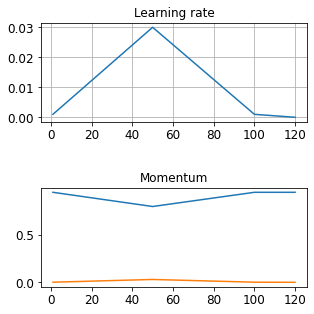

In [149]:
def plot_learning_curves(loss, val_loss, binary_accuracy, val_binary_accuracy, save_res_dir: str = None):
    plt.plot(np.arange(len(loss)) + 0.5, loss, ".-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, ".-", label="Validation loss")
    plt.plot(np.arange(len(binary_accuracy)) + 0.5, binary_accuracy, ".-", label="Training binary_accuracy")
    plt.plot(np.arange(len(val_binary_accuracy)) + 1, val_binary_accuracy, ".-", label="Validation binary_accuracy")
#     plt.plot(np.arange(len(binary_crossentropy)) + 0.5, binary_crossentropy, ".-", label="Training binary_crossentropy")
#     plt.plot(np.arange(len(val_binary_crossentropy)) + 1, val_binary_crossentropy, ".-", label="Validation binary_crossentropy")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 220, 0, 1.0])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    if save_res_dir is not None:
        fname = os.path.join(save_res_dir, 'history.svg')
        log.info(f'Saving learning history plot to {fname}')
        plt.savefig(fname, format='svg')
    plt.show()

def plot_lr_momentum(lrs: list, momentums: list):
    fig, axs = plt.subplots(2, 1, figsize=[5, 5])
    axs[0].plot(np.array(history.epoch) + 1, lrs)
    axs[0].grid()
    axs[0].set_title('Learning rate')
    axs[1].plot(np.array(history.epoch) + 1, momentums)
    axs[1].set_title('Momentum')
    axs[1].grid(True)
    fig.tight_layout(pad=3.0)
    fig.show()
    
plot_lr_momentum(learning_rates, momentum_rates)
plt.plot(np.array(history.epoch) + 1, learning_rates)
plt.grid()

# Sample model metrics after training

In [96]:
y_pred = model.predict((X_test_CNN, X_test_Dense))
log.info(f'\n\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}\n')

INFO:tensorflow:

Predicted min, max range: (8.666842e-14, 0.9999448)



In [101]:
# Applying treshold for classification probability
_y_pred = np.copy(y_pred)
_pred_one = np.where(_y_pred >= 0.9)
_pred_zero = np.where(_y_pred < 0.9)

_y_pred[_pred_one] = 1.0
_y_pred[_pred_zero] = 0.0

## Confusion matrixes

total: 164870
[[0.91264633 0.04017104]
 [0.0365864  0.01059623]]


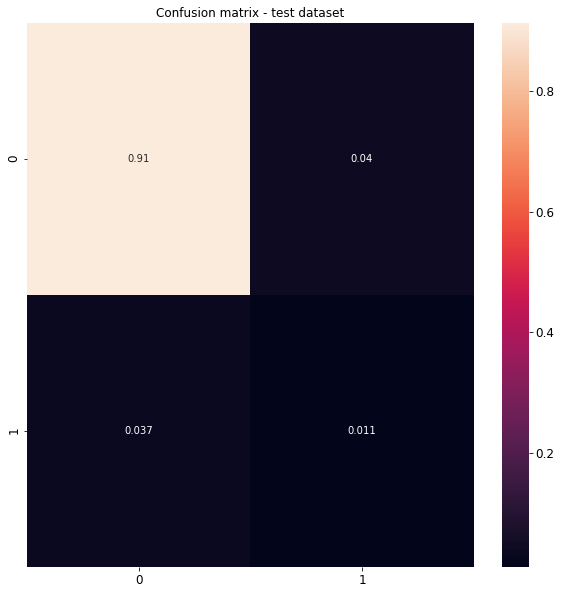

In [102]:
plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_test, _y_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_test.svg')
plt.title('Confusion matrix - test dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 1148002
[[0.93344175 0.02562104]
 [0.01561583 0.02532138]]


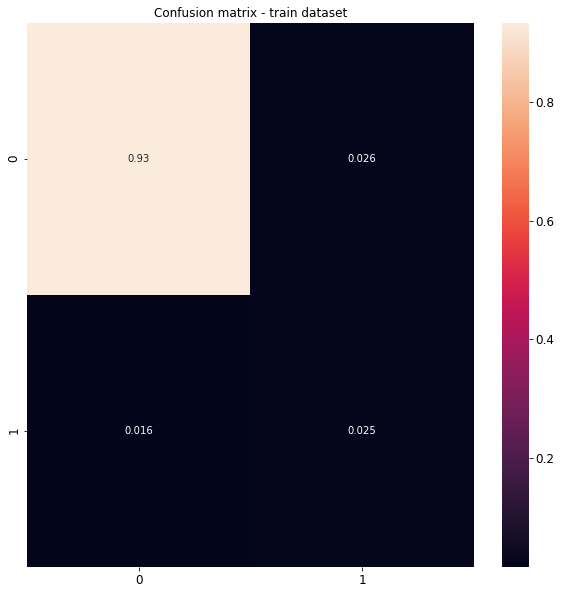

In [103]:
y_train_pred = model.predict((X_train_CNN, X_train_Dense))
_y_train_pred = np.copy(y_train_pred)
_pred_one = np.where(_y_train_pred >= 0.9)
_pred_zero = np.where(_y_train_pred < 0.9)

_y_train_pred[_pred_one] = 1.0
_y_train_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_train, _y_train_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_train.svg')
plt.title('Confusion matrix - train dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

total: 327662
[[0.9249501  0.03493234]
 [0.03033919 0.00977837]]


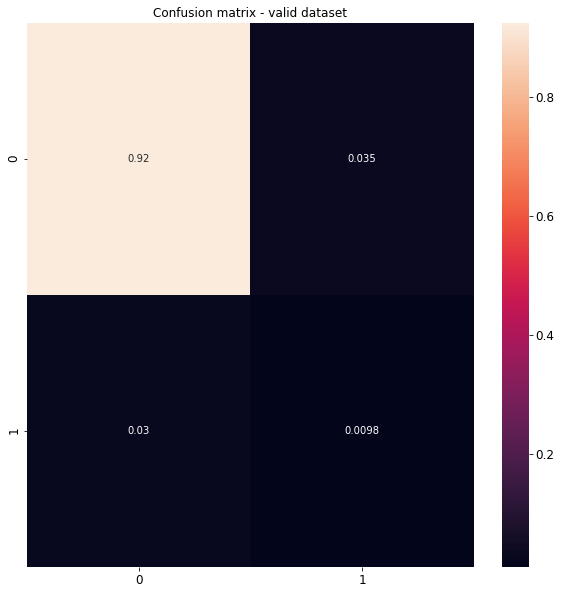

In [104]:
y_valid_pred = model.predict((X_valid_CNN, X_valid_Dense))
_y_valid_pred = np.copy(y_valid_pred)
_pred_one = np.where(_y_valid_pred >= 0.9)
_pred_zero = np.where(_y_valid_pred < 0.9)

_y_valid_pred[_pred_one] = 1.0
_y_valid_pred[_pred_zero] = 0.0

plt.figure(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_valid, _y_valid_pred)
print(f'total: {np.sum(cm)}')
cm = cm / np.sum(cm)
print(cm)
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 'xx-large'})
fname = os.path.join(run_logdir, 'confusion_matrix_valid.svg')
plt.title('Confusion matrix - valid dataset')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.savefig(fname, format='svg')
plt.show()

## Classification reports

In [105]:
report = sklearn.metrics.classification_report(y_test, _y_pred)
print('Test dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Test dataset
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    157091
           1       0.21      0.22      0.22      7779

    accuracy                           0.92    164870
   macro avg       0.59      0.59      0.59    164870
weighted avg       0.93      0.92      0.92    164870



In [106]:
report = sklearn.metrics.classification_report(y_train, _y_train_pred)
print('Train dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_train.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Train dataset
              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1101006
           1       0.50      0.62      0.55     46996

    accuracy                           0.96   1148002
   macro avg       0.74      0.80      0.76   1148002
weighted avg       0.96      0.96      0.96   1148002



In [107]:
report = sklearn.metrics.classification_report(y_valid, _y_valid_pred)
print('Valid dataset')
print(report)
with open(os.path.join(run_logdir, 'classification_report_test_valid.txt'), 'w') as cr_file:
    cr_file.writelines(report)

Valid dataset
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    314517
           1       0.22      0.24      0.23     13145

    accuracy                           0.93    327662
   macro avg       0.59      0.60      0.60    327662
weighted avg       0.94      0.93      0.94    327662



## ROC curve

In [108]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives rate (1-Specificity) [%]')
    plt.ylabel('True positives rate (Sensitivity) [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

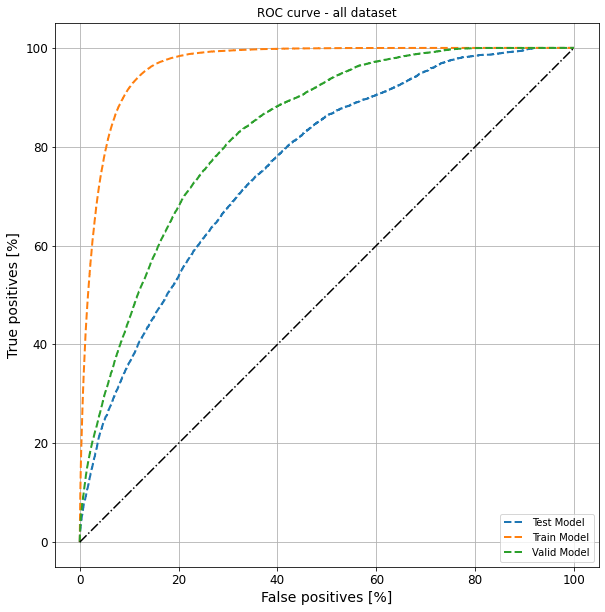

In [109]:
plt.figure(figsize=(10,10))
plot_roc("Test Model", y_test, y_pred, linestyle='--')
plot_roc("Train Model", y_train, y_train_pred, linestyle='--')
plot_roc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.plot([0, 100], [0, 100], '-.', c='black')
plt.legend(loc='lower right')
fname = os.path.join(run_logdir, 'roc_curve_all.svg')
plt.title('ROC curve - all dataset')
plt.savefig(fname, format='svg')
plt.show()

## PRC - curve

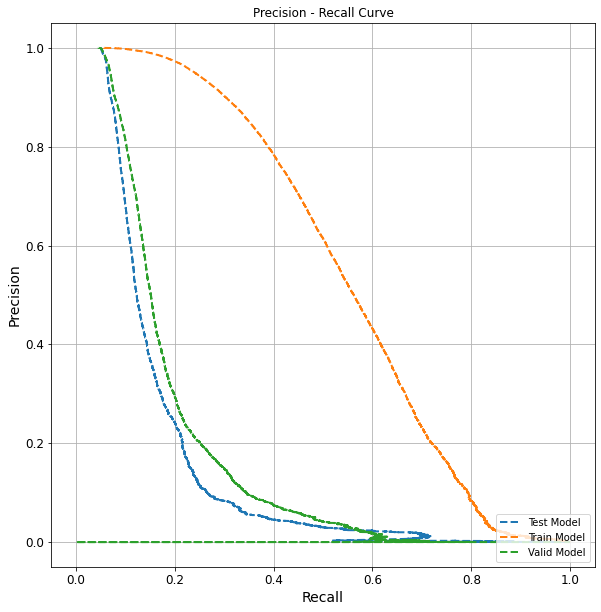

In [110]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    

plt.figure(figsize=(10,10))
plot_prc("Test Model", y_test, y_pred, linestyle='--')
plot_prc("Train Model", y_train, y_train_pred, linestyle='--')
plot_prc("Valid Model", y_valid, y_valid_pred, linestyle='--')
plt.legend(loc='lower right')
plt.title('Precision - Recall Curve')
fname = os.path.join(run_logdir, 'prc_curve.svg')
plt.savefig(fname, format='svg')
plt.show()

# Saving the model

In [29]:
experiment_run_id = run_logdir.split(sep='/')[-1]
model.save(os.path.join(run_logdir, f'trained_model-{experiment_run_id}'))
copyfile('entry_model-categorical-crypto.ipynb', os.path.join(run_logdir, 'entry_model-categorical-crypto.ipynb'))